# NOAA 1158: Cooling Model
Simulation of loops in AR NOAA 1158 in which the loops are essentially only allowed to cool, i.e. they are heated by a single pulse at $t=0$ s and then the simulation is run for a sufficiently long enough time so that even the longest loops can cool and drain back to their equilibrium state.

We will use the base field model that we've already built for NOAA 1158, AR #2 in Warren et al. (2012)

In [1]:
import os
import glob
import warnings
import multiprocessing
import subprocess
warnings.filterwarnings('ignore')

import numpy as np
from sunpy.map import Map
import sunpy
import yt
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.colors
import dask.distributed

import synthesizAR
from synthesizAR.model_ext import EbtelInterface,UniformHeating,calculate_free_energy
from synthesizAR.instruments import InstrumentSDOAIA

%matplotlib inline

 using cli
 using CLI for selections
Traceback (most recent call last):
  File "/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/ChiantiPy/tools/data.py", line 22, in <module>
    xuvtop = os.environ['XUVTOP']
  File "/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/os.py", line 725, in __getitem__
    raise KeyError(key) from None
KeyError: 'XUVTOP'



First, start up a dask scheduler and worker on the localhost.

In [2]:
client = dask.distributed.Client()
client

Client Scheduler: tcp://127.0.0.1:48512 Dashboard: http://127.0.0.1:8787,Cluster Workers: 64 Cores: 64 Memory: 162.23 GB


## Build Field

In [ ]:
field = synthesizAR.Skeleton.restore('/data/datadrive2/systematic_ar_study/base_noaa1158')

## Heating Model and Loop Configuration

For the loop simulations, we'll use a single pulse of duration 200 s at $t=0$ s with total energy of 

$$
E_s = \frac{(\epsilon B_s)^2}{8\pi}
$$

where $B_s$ is the average field strength along a strand $s$.

Setup all of our loop models using this single-event/cooling model.

In [ ]:
heating_options = {
    'duration':200,
    'average_waiting_time':8800,
    'duration_rise':100,
    'duration_decay':100,
    'stress_level':0.1
}
heating_model = UniformHeating(heating_options)

In [ ]:
ih = synthesizAR.util.InputHandler('/home/wtb2/Documents/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml')
base_config = ih.lookup_vars()
base_config['c1_cond0'] = 6.0
base_config['total_time'] = 1e4
base_config['use_adaptive_solver'] = True
base_config['use_flux_limiting'] = True
base_config['calculate_dem'] = False
base_config['heating']['partition'] = 1.0
base_config['heating']['background'] = 1e-6
base_config['force_single_fluid'] = False
base_config['tau_max'] = 200.0

In [ ]:
ebtel_interface = EbtelInterface(base_config,heating_model,
                                 '/data/datadrive2/systematic_ar_study/noaa1158_cooling/hydro_config/',
                                 '/data/datadrive2/systematic_ar_study/noaa1158_cooling/hydro_results/')

In [ ]:
field.configure_loop_simulations(ebtel_interface)

Now run all of our models and load them back into the field.

In [ ]:
def ebtel_runner(loop):
    subprocess.call([os.path.join('/home/wtb2/Documents/codes/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [ ]:
pool = multiprocessing.Pool()

In [ ]:
runs = pool.map_async(ebtel_runner,field.loops)
runs.wait()

In [ ]:
field.load_loop_simulations(ebtel_interface,
                            savefile='/data/datadrive2/systematic_ar_study/noaa1158_cooling/loop_parameters.h5')

And save the field.

In [ ]:
field.save('/data/datadrive2/systematic_ar_study/noaa1158_cooling/field_checkpoint')

Peek at the hydrodynamic simulation results.

In [ ]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
for loop in field.loops[::10]:
    axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),color=sns.color_palette('deep')[0],alpha=0.01)
    axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color=sns.color_palette('deep')[2],alpha=0.01)
    axes[1].plot(loop.time,loop.density[:,0]/1e9,color=sns.color_palette('deep')[0],alpha=0.05)
axes[0].set_xlim([0,base_config['total_time']])
axes[0].set_ylabel(r'$T$ [MK]')
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]')
axes[1].set_xlabel(r'$t$ [s]')

Restore the field here if necessary.

In [3]:
field = synthesizAR.Skeleton.restore('/storage-home/w/wtb2/data/noaa1158_cooling_model/field_checkpoint/')

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-09-15 11:29:03,211 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-09-15 11:29:03,212 Parameters: domain_dimensions         = [95 96 96]
yt : [INFO     ] 2017-09-15 11:29:03,212 Parameters: domain_left_edge          = [ -2.96081016e+10  -2.62091384e+10   3.91869796e+08]
yt : [INFO     ] 2017-09-15 11:29:03,213 Parameters: domain_right_edge         = [ -1.18463315e+10  -7.41270210e+09   1.92016200e+10]
yt : [INFO     ] 2017-09-15 11:29:03,214 Parameters: cosmological_simulation   = 0.0


Modify savefile location of all loops. This path should really be relative...

In [8]:
for loop in field.loops:
    loop.parameters_savefile = '/storage-home/w/wtb2/data/noaa1158_cooling_model/loop_parameters.h5'

## Instrument Intensity Synthesis

In [4]:
aia = InstrumentSDOAIA([0,10000]*u.s)

In [10]:
observer = synthesizAR.Observer(field,[aia])

In [11]:
observer.build_detector_files('/storage-home/w/wtb2/data/noaa1158_cooling_model/',
                              ds=field._convert_angle_to_length(1.2*u.arcsec))

In [12]:
flatten_dag = observer.flatten_detector_counts()

In [14]:
flatten_dag['SDO_AIA'].compute(resources={'MEMORY':'64GB'})

## Build Maps

In [15]:
bin_dag = observer.bin_detector_counts('/storage-home/w/wtb2/data/noaa1158_cooling_model/')

In [16]:
jobs = client.compute(bin_dag['SDO_AIA'])

## Visualization

In [5]:
data_root = '/storage-home/w/wtb2/data/noaa1158_cooling_model'

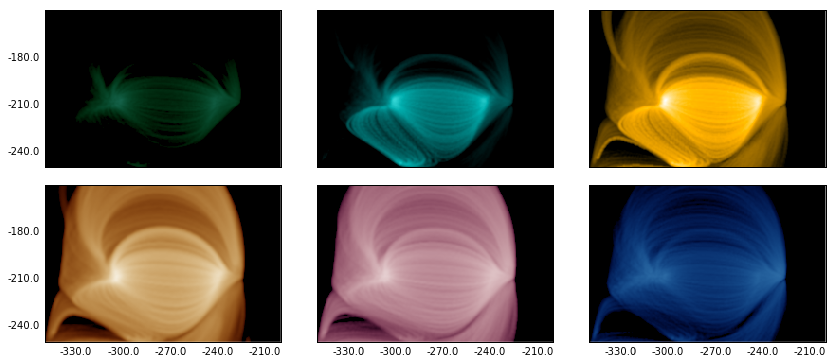

In [50]:
time_step = np.where(aia.observing_time==2500*u.s)[0][0]
fig = plt.figure(figsize=(11.5,5))
for i,channel in enumerate(aia.channels):
    tmp = Map(os.path.join(data_root,aia.name,channel['name'],'map_t{:06d}.fits'.format(time_step)))
    tmp = tmp.submap(u.Quantity([-350,-200],u.arcsec),u.Quantity([-250,-150],u.arcsec))
    ax = fig.add_subplot(2,3,i+1,projection=tmp)
    im = tmp.plot(axes=ax,annotate=False,norm=matplotlib.colors.SymLogNorm(1e-3,vmin=1,vmax=1e4))
    ax.coords[0].grid(draw_grid=False)
    ax.coords[1].grid(draw_grid=False)
    if i%3 != 0:
        ax.coords[1].set_ticklabel_visible(False)
    if i<3:
        ax.coords[0].set_ticklabel_visible(False)
plt.tight_layout()
#fig.colorbar()